# Bitcoin Data Analysis

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

## Load datasets: Interest (google trends) & Price
Two datasets are manually arranged in `data/DatasetPreparation.ipynb`:
- Google searches of term 'bitcoin' worldwide and daily since 2015: `google_trends_bitcoin_2015_2021_daily.csv`
- Price action hourly from Gemini: `Gemini_BTCUSD_2015_2021_hourly.csv`

In [2]:
# Halving dates
h2 = dt.datetime(2016,7,9,0,0,0)
h3 = dt.datetime(2020,5,11,0,0,0)

In [3]:
df_interest = pd.read_csv('data/google_trends_bitcoin_2015_2021_daily.csv',header=0)

In [4]:
df_interest['date'] = pd.to_datetime(df_interest['date'])

In [5]:
df_interest.set_index('date',inplace=True)

In [6]:
# Nomalization
max_interest = df_interest['bitcoin_searches_world'].max()
df_interest['bitcoin_searches_world'] = 100 * df_interest['bitcoin_searches_world'] / max_interest

In [7]:
df_interest.head()

,bitcoin_searches_world
date,
2015-01-01,1.117081
2015-01-02,1.311356
2015-01-03,1.359924
2015-01-04,1.602768
2015-01-05,1.505630


In [8]:
df_interest.describe()

,bitcoin_searches_world
count,2502.000000
mean,8.541811
std,9.766172
min,0.827235
25%,1.810133
50%,5.971429
75%,9.807770
max,100.000000


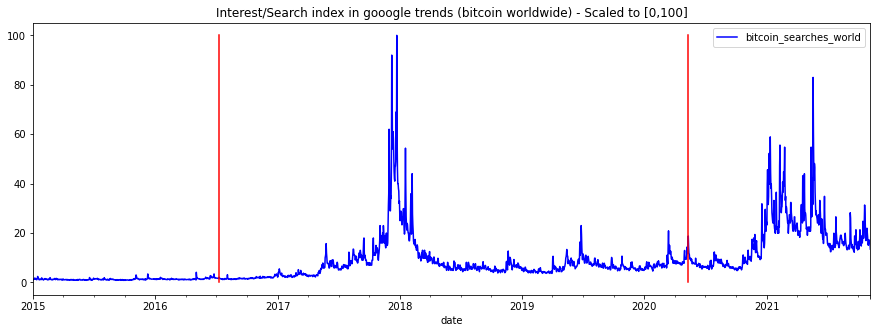

In [9]:
#%matplotlib ipympl
%matplotlib inline
#df_interest.plot(x='date',y='bitcoin_searches_world',figsize=(15,5),color='r')
df_interest.plot(y='bitcoin_searches_world',figsize=(15,5),color='b')
plt.plot([h2,h2],[0,df_interest['bitcoin_searches_world'].max()],color='r')
plt.plot([h3,h3],[0,df_interest['bitcoin_searches_world'].max()],color='r')
plt.title('Interest/Search index in gooogle trends (bitcoin worldwide) - Scaled to [0,100]')
plt.show()

In [10]:
df_price = pd.read_csv('data/Gemini_BTCUSD_2015_2021_hourly.csv',header=0)

In [11]:
df_price['Date'] = pd.to_datetime(df_price['Date'])

In [12]:
df_price.set_index('Date',inplace=True)

In [13]:
df_price.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632


In [14]:
df_price.describe()

,Open,High,Low,Close,Volume
count,51641.000000,51641.000000,51641.000000,51641.000000,53340.000000
mean,11609.108516,11677.237696,11535.721282,11610.351007,135.848680
std,15351.166253,15445.510283,15249.242494,15352.738682,266.569872
min,0.000000,243.600000,0.000000,243.600000,0.000000
25%,1191.520000,1194.990000,1188.110000,1191.540000,18.511616
50%,6904.010000,6941.990000,6867.820000,6904.220000,55.876222
75%,10673.380000,10723.560000,10610.700000,10673.690000,144.784211
max,66892.380000,66994.720000,66357.600000,66892.380000,8526.751048


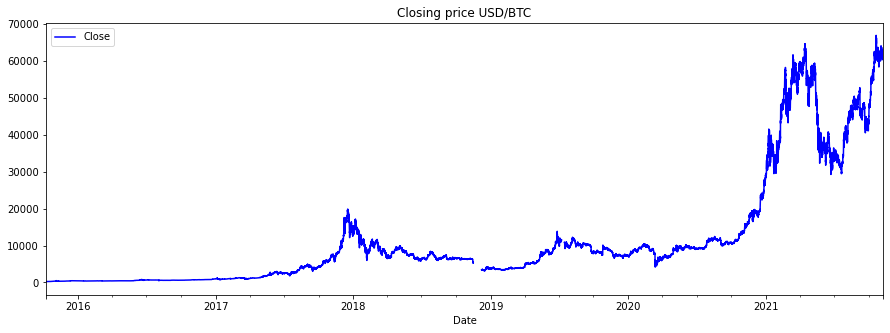

In [15]:
#%matplotlib ipympl
%matplotlib inline
df_price.plot(y='Close',figsize=(15,5),color='b')
ax = plt.gca()
ax.plot([h2,h2],[0,df_price['Close'].max()],color='r')
ax.plot([h3,h3],[0,df_price['Close'].max()],color='r')
plt.title('Closing price USD/BTC')
plt.show()

## 1. Preliminary Analysis
Halving epochs are analyzed starting from the halving date until the ATH.
The number of hours at each price level is computed and ploted.

In [16]:
# Halving 2016: 2016-07-09
# ATH 2017: 2017-12-17
#start = dt.datetime(2016,7,9,0,0,0)
#end = dt.datetime(2017,12,17,0,0,0)
#end = dt.datetime(2017,9,15,0,0,0)
# Halving 2020: 2020-05-11
# ATH 2021: ?
start = dt.datetime(2020,5,11,0,0,0)
end = dt.datetime(2021,11,8,0,0,0)
if (df_price.index[-1] < end or df_interest.index[-1] < end):
    end = min([df_price.index[-1],df_interest.index[-1]])
duration_days = (end-start).days

In [17]:
duration_days

544

In [18]:
df_price.loc[start:end].shape

(13057, 5)

<AxesSubplot:xlabel='Date'>

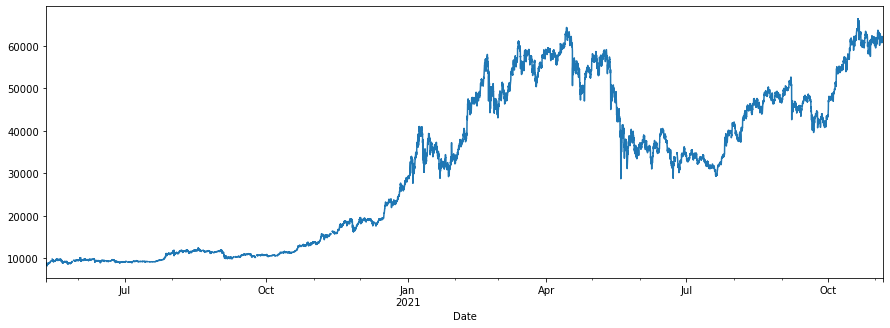

In [19]:
#%matplotlib ipympl
%matplotlib inline
df_price['Low'].loc[start:end].plot(figsize=(15,5))

In [20]:
df_window = df_price.loc[start:end]
n = 100
max_price = df_window['Low'].max()
min_price = df_window['Low'].min()
ref_price = df_window['Low'].iloc[0]
print('min_price = {}, ref_price = {}, max_price = {}'.format(min_price, ref_price, max_price))

min_price = 8200.0, ref_price = 8709.62, max_price = 66357.6


In [21]:
df_price['Factor'] = df_price['Low']/ref_price
df_window = df_price.loc[start:end]
max_factor = df_window['Factor'].max()
min_factor = df_window['Factor'].min()
step_factor = (max_factor - min_factor) / (n-1)
step_price = (max_price - min_price) / (n-1)
print('min_factor = {}, max_factor = {}, step_factor = {}, step_price = {}'.format(min_factor, max_factor, step_factor, step_price))

min_factor = 0.9414876883262415, max_factor = 7.6188857837655375, step_factor = 0.06744846561049794, step_price = 587.4505050505051


In [22]:
price_bins = np.zeros(n)
for i in range(df_window.shape[0]):
    if not (np.isnan(df_window.iloc[i]['Low'])):
        b = np.int(np.floor((df_window.iloc[i]['Low'] - min_price) / step_price))
        price_bins[b] = price_bins[b] + 1

In [23]:
price_bins

array([ 61., 949., 722., 355., 611., 758., 257.,  43., 180., 127.,  17.,
        49., 110.,  86.,  59.,  40., 129., 178., 258.,  28.,   1.,   7.,
         5.,   8.,  62.,  87.,  48.,  11.,  12.,   7.,  15.,  49.,  16.,
        14.,  19.,  47.,  40.,  24.,  61., 173., 162., 214., 173., 238.,
       211., 128., 189., 159., 159., 153., 136., 130., 130., 131.,  84.,
        52.,  66.,  62.,  80.,  99.,  76., 106., 122., 126., 168., 175.,
       228., 208., 202., 178., 140., 114.,  63.,  77.,  50.,  41.,  51.,
       107., 157., 154., 138., 154., 163., 177., 161., 138., 109.,  85.,
        89., 150., 108.,  88.,  94.,  53.,  25.,   9.,   5.,   6.,   6.,
         1.])

Text(0, 0.5, 'Number of hours')

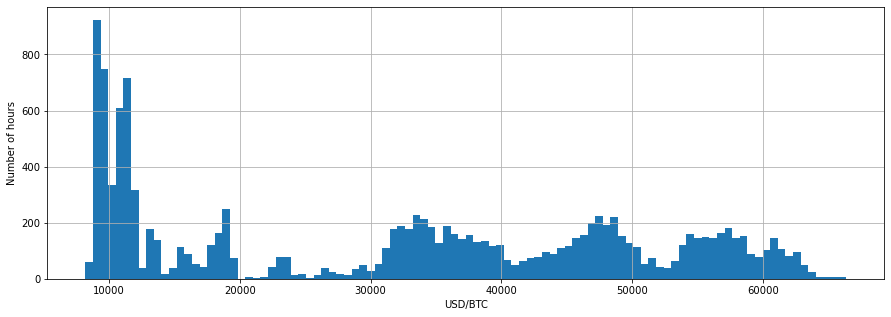

In [24]:
df_window['Low'].hist(bins=100,figsize=(15,5))
plt.xlabel('USD/BTC')
plt.ylabel('Number of hours')

Text(0, 0.5, 'Number of hours')

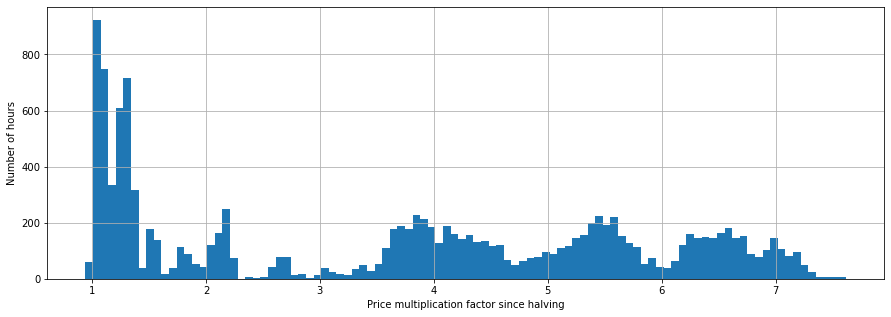

In [25]:
df_window['Factor'].hist(bins=100,figsize=(15,5))
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours')

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Number of hours')

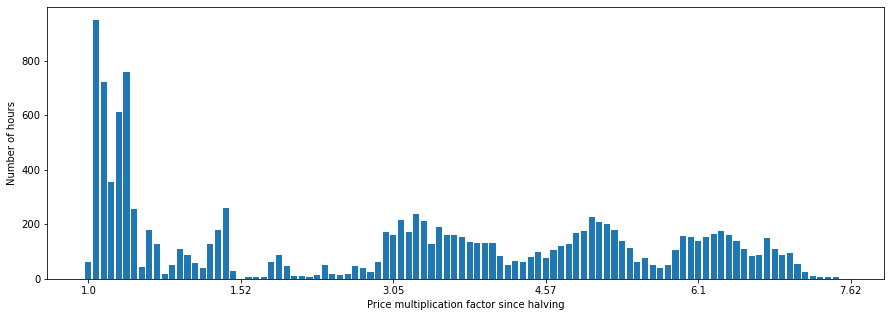

In [26]:
#%matplotlib ipympl
%matplotlib inline
plt.figure(figsize=(15,5))
#plt.bar(x=np.linspace(min_price,max_price,n),height=price_bins)
plt.bar(x=range(n),height=price_bins)
ax = plt.gca()
ticks = ax.get_xticks()
new_ticks = np.round(max_factor*ticks/100,decimals=2)
new_ticks[1] = 1
ax.set_xticklabels(new_ticks)
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours')

In [27]:
acc_price_bins = np.zeros(n)
l = range(n)
for i in l[::-1]:
    acc_price_bins[i] = price_bins[i:-1].sum()

In [28]:
x = np.linspace(min_price,max_price,n)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0, 0.5, 'Number of hours in factor range or smaller')

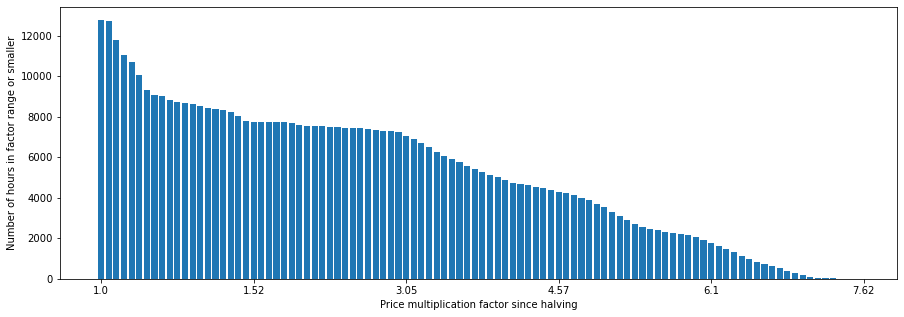

In [29]:
plt.figure(figsize=(15,5))
plt.bar(x=range(n),height=acc_price_bins)
ax = plt.gca()
ticks = ax.get_xticks()
new_ticks = np.round(max_factor*ticks/100,decimals=2)
new_ticks[1] = 1
ax.set_xticklabels(new_ticks)
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours in factor range or smaller')

In [30]:
acc_price_bins

array([1.2780e+04, 1.2719e+04, 1.1770e+04, 1.1048e+04, 1.0693e+04,
       1.0082e+04, 9.3240e+03, 9.0670e+03, 9.0240e+03, 8.8440e+03,
       8.7170e+03, 8.7000e+03, 8.6510e+03, 8.5410e+03, 8.4550e+03,
       8.3960e+03, 8.3560e+03, 8.2270e+03, 8.0490e+03, 7.7910e+03,
       7.7630e+03, 7.7620e+03, 7.7550e+03, 7.7500e+03, 7.7420e+03,
       7.6800e+03, 7.5930e+03, 7.5450e+03, 7.5340e+03, 7.5220e+03,
       7.5150e+03, 7.5000e+03, 7.4510e+03, 7.4350e+03, 7.4210e+03,
       7.4020e+03, 7.3550e+03, 7.3150e+03, 7.2910e+03, 7.2300e+03,
       7.0570e+03, 6.8950e+03, 6.6810e+03, 6.5080e+03, 6.2700e+03,
       6.0590e+03, 5.9310e+03, 5.7420e+03, 5.5830e+03, 5.4240e+03,
       5.2710e+03, 5.1350e+03, 5.0050e+03, 4.8750e+03, 4.7440e+03,
       4.6600e+03, 4.6080e+03, 4.5420e+03, 4.4800e+03, 4.4000e+03,
       4.3010e+03, 4.2250e+03, 4.1190e+03, 3.9970e+03, 3.8710e+03,
       3.7030e+03, 3.5280e+03, 3.3000e+03, 3.0920e+03, 2.8900e+03,
       2.7120e+03, 2.5720e+03, 2.4580e+03, 2.3950e+03, 2.3180e

In [31]:
acc_price_bins[80:-1]

array([1758., 1620., 1466., 1303., 1126.,  965.,  827.,  718.,  633.,
        544.,  394.,  286.,  198.,  104.,   51.,   26.,   17.,   12.,
          6.])

In [32]:
# Arrange a custom dataframe
df_tmp = pd.DataFrame()
df_tmp['close'] = df_price['Close'].resample(rule='D').last().loc[start:end]
df_tmp['factor'] = df_price['Factor'].resample(rule='D').last().loc[start:end]
df_tmp['interest'] = df_interest['bitcoin_searches_world'].loc[start:end]
df_tmp['date'] = df_interest.loc[start:end].index
df_tmp['day'] = range((end-start).days+1)

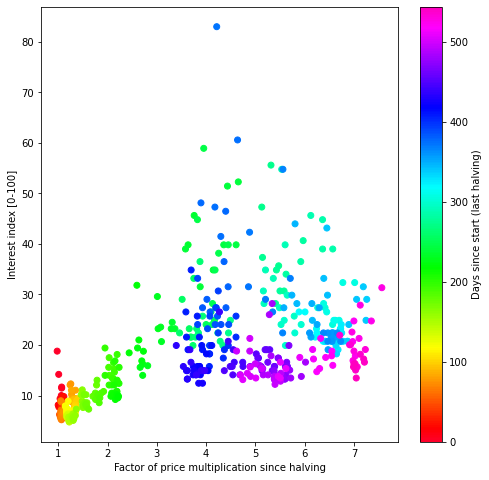

In [33]:
plt.figure(figsize=(8,8))
#df1.plot.scatter(x='A',y='B',c='C',cmap='coolwarm')
#https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#plt.scatter(x=df_tmp['factor'],y=df_tmp['interest'],c=df_tmp['day'],cmap='coolwarm')
plt.scatter(x=df_tmp['factor'],y=df_tmp['interest'],c=df_tmp['day'],cmap='gist_rainbow')
plt.xlabel('Factor of price multiplication since halving')
plt.ylabel('Interest index [0-100]')
cbar = plt.colorbar()
cbar.set_label('Days since start (last halving)')

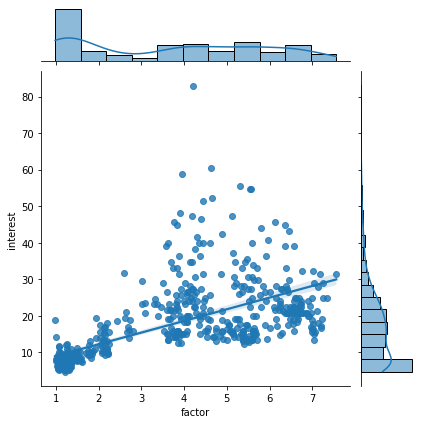

In [34]:
sns.jointplot(x='factor',y='interest',data=df_tmp,kind='reg')

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
df_tmp.corr()

,close,factor,interest,day
close,1.000000,0.999936,0.624476,0.844836
factor,0.999936,1.000000,0.620587,0.844835
interest,0.624476,0.620587,1.000000,0.440458
day,0.844836,0.844835,0.440458,1.000000


In [37]:
lm = LinearRegression()

In [38]:
X = df_tmp['factor'].values.reshape(df_tmp['factor'].shape[0],1)
X.shape

(545, 1)

In [39]:
y = df_tmp['interest'].values.reshape(df_tmp['interest'].shape[0],1)
y.shape

(545, 1)

In [40]:
lm.fit(X,y)

LinearRegression()

In [41]:
# Intercept
lm.intercept_

array([5.85459686])

In [42]:
# Slope
lm.coef_

array([[3.18981396]])

In [43]:
predictions = lm.predict(X)

Text(0, 0.5, 'Predicted interest')

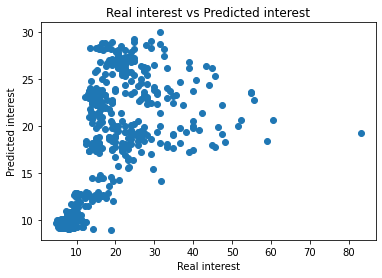

In [44]:
plt.scatter(x=y,y=predictions)
plt.title('Real interest vs Predicted interest')
plt.xlabel('Real interest')
plt.ylabel('Predicted interest')

## 2. Low and Upper Baselines

In [45]:
# low
# 2020-07-20
# 2020-10-18
# 2020-11-27
# 2021-07-21
# 2021-10-01
low_dates = np.array([dt.datetime(2020,7,20,0,0,0),
             dt.datetime(2020,10,18,0,0,0),
             dt.datetime(2020,11,27,0,0,0),
             dt.datetime(2021,7,21,0,0,0),
             dt.datetime(2021,10,1,0,0,0)])
low_days = low_dates - h3
low_days = np.array([d.days for d in low_days])
# up
# 2020-08-18
# 2020-11-30
# 2021-01-09
# 2021-02-22
# 2021-04-14
high_dates = np.array([dt.datetime(2020,8,18,0,0,0),
              dt.datetime(2020,11,30,0,0,0),
              dt.datetime(2021,1,9,0,0,0),
              dt.datetime(2021,2,22,0,0,0),
              dt.datetime(2021,4,14,0,0,0)])
high_days = high_dates - h3
high_days = np.array([d.days for d in high_days])

In [46]:
low_days

array([ 70, 160, 200, 436, 508])

In [47]:
high_days

array([ 99, 203, 243, 287, 338])

In [48]:
# DEGREE of polynomials
degree = 2

In [49]:
# Low polynomial: Support
x = low_days
X = np.vander(x, N=degree+1, increasing=True)
y = df_tmp['close'].loc[low_dates].values

In [50]:
X_pinv = np.linalg.pinv(X)
b_low = np.matmul(X_pinv,y)

In [51]:
b_low

array([ 1.00859744e+04, -1.20644498e+01,  1.62518822e-01])

In [52]:
# High polynomial: Resistance
x = high_days
X = np.vander(x, N=degree+1, increasing=True)
y = df_tmp['close'].loc[high_dates].values
X_pinv = np.linalg.pinv(X)
b_high = np.matmul(X_pinv,y)

In [53]:
b_high

array([ 5.95125494e+03, -9.00979296e+00,  5.53863193e-01])

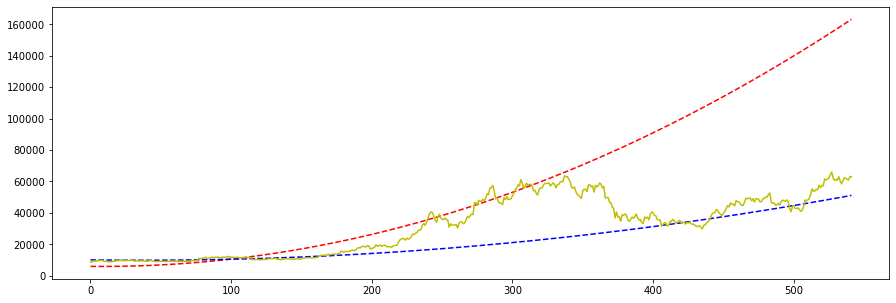

In [66]:
today = dt.datetime(2021,11,4,0,0,0)
x = np.arange((today-h3).days)
y_low = np.zeros(len(x))
y_high = np.zeros(len(x))
for i in range(len(b_low)):
    b = b_low[i]
    y_low = y_low + b*(x**i)
for i in range(len(b_high)):
    b = b_high[i]
    y_high = y_high + b*(x**i)
plt.figure(figsize=(15,5))
plt.plot(x,y_high,'r--')
plt.plot(x,y_low,'b--')
#
y_close = df_tmp['close'].values
min_d = min(len(x),len(y_close))
plt.plot(x[:min_d],y_close[:min_d],'y')

## 3. Comparisons

In [74]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
%matplotlib inline
#%matplotlib notebook

In [76]:
# Halving 2016: 2016-07-09
# ATH 2017: 2017-12-17
#start = dt.datetime(2016,7,9,0,0,0)
#end = dt.datetime(2017,12,17,0,0,0)
#end = dt.datetime(2017,9,15,0,0,0)
# Halving 2020: 2020-05-11
# ATH 2021: ?
start = dt.datetime(2020,5,11,0,0,0)
end = dt.datetime(2021,11,8,0,0,0)

In [111]:
df_btc = pd.read_csv('data/Gemini_BTCUSD_2015_2021_hourly.csv',header=0)
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc.set_index('Date',inplace=True)

In [112]:
df_btc.head()

,Open,High,Low,Close,Volume BTC
Date,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632


In [113]:
df_eth = pd.read_csv('data/Bitstamp_ETHUSD_2017_2021_hourly.csv',header=0)
df_eth['Date'] = pd.to_datetime(df_eth['Date'])
df_eth.set_index('Date',inplace=True)

In [114]:
df_eth.head()

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2017-08-16 16:00:00,300.0,300.0,300.0,300.0,0.02,6.0
2017-08-16 17:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 18:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 19:00:00,300.0,300.0,300.0,300.0,0.00,0.0
2017-08-16 20:00:00,300.0,300.0,300.0,300.0,0.00,0.0


In [115]:
df_spy = data.DataReader("SPY", 'yahoo', start, end)

In [116]:
df_spy.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-11,294.000000,289.880005,290.339996,292.500000,79514200.0,286.028229
2020-05-12,294.239990,286.519989,293.790009,286.670013,95870800.0,280.327240
2020-05-13,287.190002,278.959991,286.059998,281.600006,144721100.0,275.369415
2020-05-14,285.109985,272.989990,278.950012,284.970001,121977900.0,278.664825
2020-05-15,286.329987,281.339996,282.369995,286.279999,111146300.0,279.945831


In [129]:
df_btc['btc'] = df_btc['Close']
df_eth['eth'] = df_eth['Close']
df = pd.concat([df_btc['btc'], df_eth['eth']], axis = 1,join='outer').dropna()

In [130]:
df = df.resample(rule='D').last().loc[start:end]

In [131]:
df_spy['spy'] = df_spy['Adj Close']
df = pd.concat([df, df_spy['spy']], axis = 1,join='outer').dropna()

<AxesSubplot:xlabel='Date'>

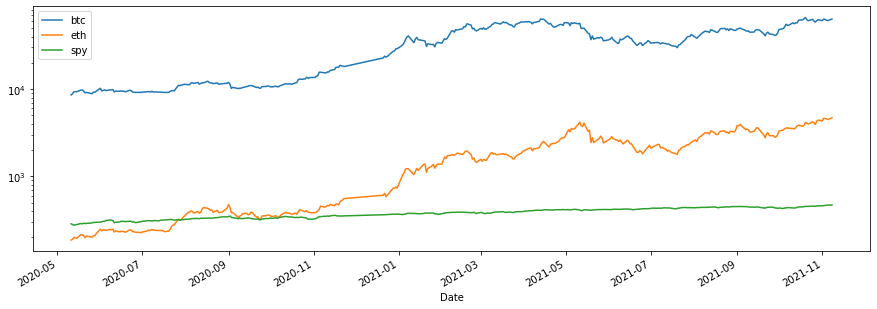

In [137]:
df.plot(figsize=(15,5),logy=True)

In [133]:
df.head()

,btc,eth,spy
Date,,,
2020-05-11,8571.50,186.18,286.028229
2020-05-12,8822.66,189.79,280.327240
2020-05-13,9311.58,199.80,275.369415
2020-05-14,9338.85,198.58,278.664825
2020-05-15,9314.16,194.57,279.945831


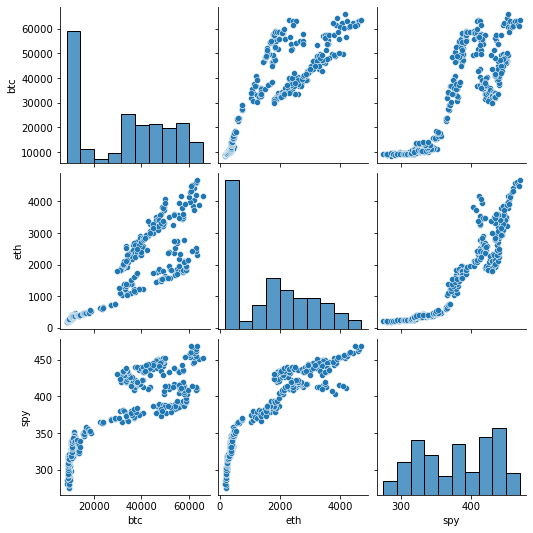

In [148]:
sns.pairplot(df)

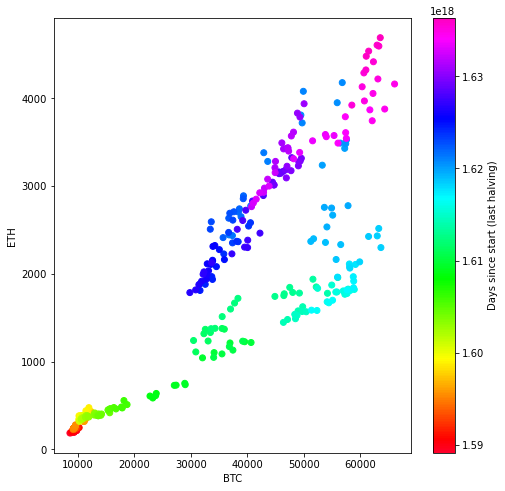

In [146]:
plt.figure(figsize=(8,8))
#https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
plt.scatter(x=df['btc'],y=df['eth'],c=df.index,cmap='gist_rainbow')
plt.xlabel('BTC')
plt.ylabel('ETH')
cbar = plt.colorbar()
cbar.set_label('Days since start (last halving)')

### Returns

In [150]:
returns = pd.DataFrame()
for asset in df.columns:
    returns[asset] = df[asset].pct_change()
# The return percent of the first day is NaN
returns.head()

,btc,eth,spy
Date,,,
2020-05-11,NaN,NaN,NaN
2020-05-12,0.029302,0.019390,-0.019932
2020-05-13,0.055416,0.052743,-0.017686
2020-05-14,0.002929,-0.006106,0.011967
2020-05-15,-0.002644,-0.020193,0.004597


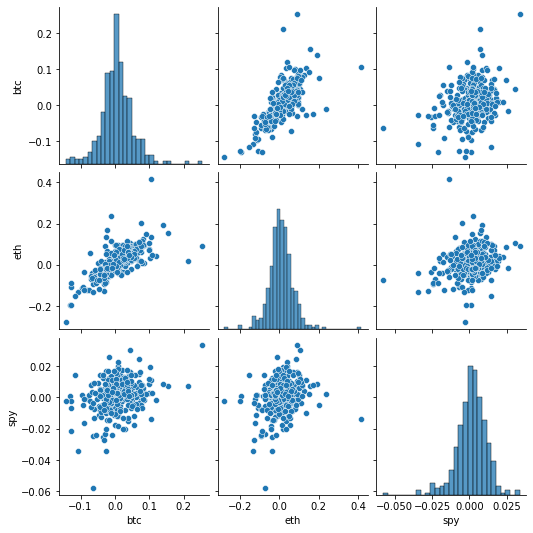

In [151]:
sns.pairplot(returns[1:].dropna())

<AxesSubplot:xlabel='eth', ylabel='Count'>

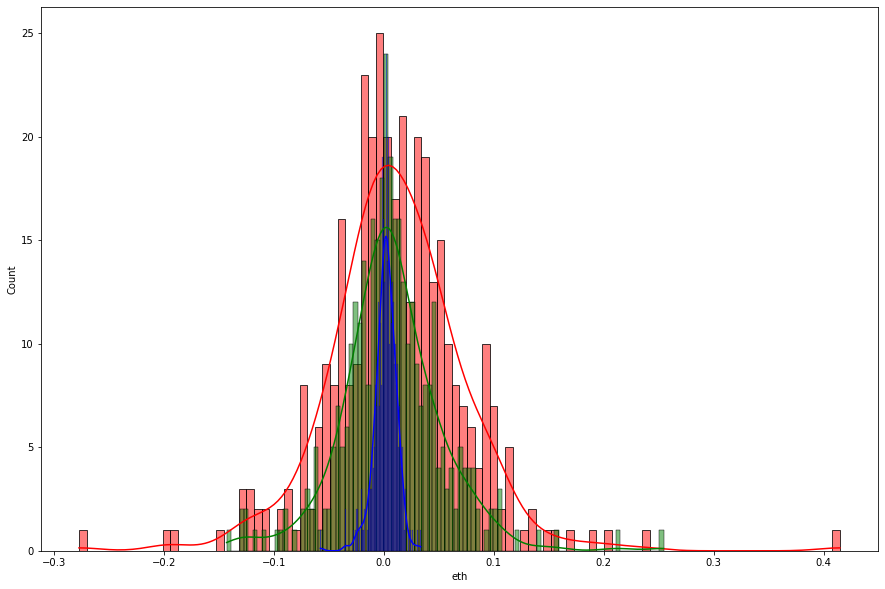

In [155]:
plt.figure(figsize=(15,10))
sns.histplot(returns['eth'],
             color='red',
             bins=100,
             kde=True)
sns.histplot(returns['btc'],
             color='green',
             bins=100,
             kde=True)
sns.histplot(returns['spy'],
             color='blue',
             bins=100,
             kde=True)

<AxesSubplot:>

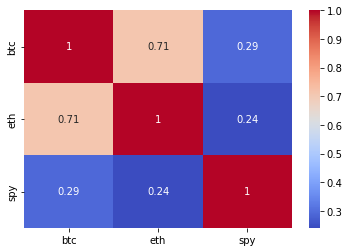

In [177]:
sns.heatmap(returns.corr(), cmap='coolwarm', annot=True)

<AxesSubplot:xlabel='Date'>

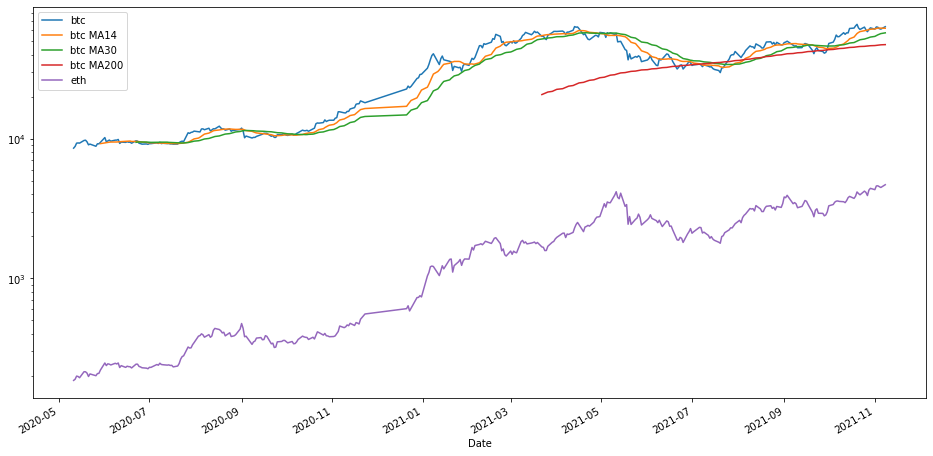

In [173]:
df['btc MA14'] = df['btc'].rolling(14).mean()
df['btc MA30'] = df['btc'].rolling(30).mean()
df['btc MA200'] = df['btc'].rolling(200).mean()
df[['btc','btc MA14','btc MA30','btc MA200','eth']].plot(figsize=(16,8),logy=True)

### Plotly

In [170]:
import plotly
import chart_studio.plotly as py
import cufflinks as cf

In [171]:
# Import plotly-offline modules
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# Connect Javascript to our notebook - this is for notebook development
init_notebook_mode(connected=True)
# In order to work offline through cufflinks, we need to run this:
cf.go_offline()

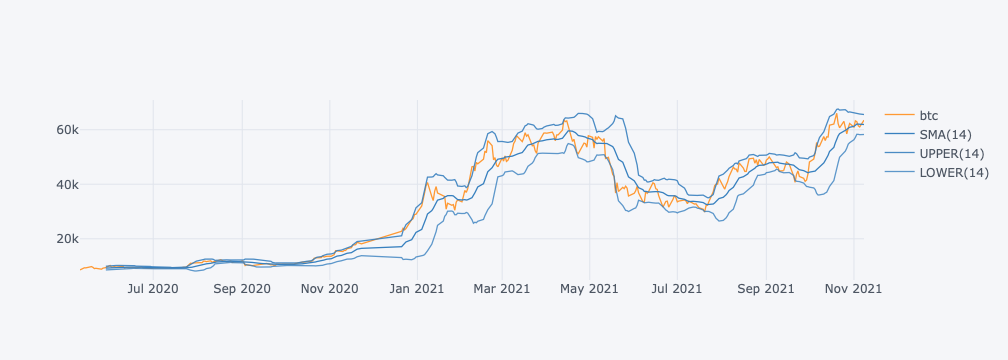

In [172]:
df['btc'].ta_plot(study='boll')